In [ ]:
%pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -------- ------------------------------- 2.6/12.9 MB 19.7 MB/s eta 0:00:01
   ---------------------------------- ----- 11.3/12.9 MB 33.2 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 31.8 MB/s  0:00:00

   ---------------------------------------- 0/3 [tifffile]
   ---------------------------------------- 0/3 [tifffile]
   ---------------------------------------- 0/3 [tifffile]
   ---------------------------------------- 0/3 [tifffile]
   ---------------------------------------- 0/3 [tifffile]
   ---------------------------------------- 0/3 [tifffile]
   ---------------------------------------- 0/3 [tifffile]
   ---------------------------------------- 0/3 [tifffile]
   ---------------------------------------- 0/3 [tifffile]
   ------------- -------------------------- 1/3 [imageio]
   ------------- ------------

In [16]:
%pip install tensorflow
%pip install tensorflow.keras
%pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from re import I
import librosa,sys
import matplotlib.pyplot as plt
import numpy as np
from librosa import display
import scipy
import math
import os
from random import *
from skimage import io
from skimage import color
from skimage.util import img_as_ubyte

def fft_plot(audio, sampling_rate):
  n=len(audio)
  T= 1/sampling_rate
  yf= scipy.fft.fft(audio)
  xf = np.linspace(0.0, 1.0/(2.0*T), n//2)
  fig, ax = plt.subplots()
  ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
  plt.grid()
  plt.xlabel("Frequency -->")
  plt.ylabel("Magnitude")
  return plt.show()

def spectrogram(samples, sample_rate, stride_ms = 10.0, window_ms = 20.0, min_freq=2000, max_freq = 10000, eps = 1e-14):
 
  stride_size = int(0.001 * sample_rate * stride_ms)
  window_size = int(0.001 * sample_rate * window_ms)

  # Extract strided windows
  truncate_size = (len(samples) - window_size) % stride_size
  samples = samples[:len(samples) - truncate_size]
  nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
  nstrides = (samples.strides[0], samples.strides[0] * stride_size)
  windows = np.lib.stride_tricks.as_strided(samples, 
                                        shape = nshape, strides = nstrides)
    
  assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

  # Window weighting, squared Fast Fourier Transform (fft), scaling
  weighting = np.hanning(window_size)[:, None]
    
  fft = np.fft.rfft(windows * weighting, axis=0)
  fft = np.absolute(fft)
  fft = fft**2
    
  scale = np.sum(weighting**2) * sample_rate
  fft[1:-1, :] *= (2.0 / scale)
  fft[(0, -1), :] /= scale
    
  # Prepare fft frequency list
  freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
  
  # Compute spectrogram feature
  startind=np.where( freqs >=min_freq)[0][0] 
  endind = np.where( freqs <=max_freq)[0][-1] + 1
  #print(str(startind)+":"+str(endind))
  specgram = np.log(fft[startind:endind, :] + eps)
  return specgram
  
def plot_bird(file_path):
  samples, sampling_rate = librosa.load(file_path, sr= None, mono=True, offset=0.0, duration = None)
  spec=spectrogram(samples,sampling_rate)
  plt.imshow(spec)
  plt.imsave("file_path")
  plt.xlabel(file_path+" Time frame windows")
  plt.ylabel("Frequency")
  plt.show()

def eval_amplitude(samples):
  max=-1
  sum=0.0
  for s in samples:
    #print(s)
    amp=s*s
    if amp > max:
      max=amp
    sum=sum+amp
  return(max,math.sqrt(sum/len(samples)),math.sqrt(sum))

def splice_sound_file(file_path,splice_length,shift):
  samples, sampling_rate = librosa.load(file_path, sr= None, mono=True, offset=0.0, duration = None)
  print("file length ",len(samples))
  sounds=[]
  remaining=len(samples)
  start=0
  ii=0
  #print("splice_length "+str(splice_length))
  #print("shift "+str(shift))
  while(remaining > 0 ):
    #print("remaining: "+str(int(remaining)))
    end=splice_length
    if(remaining < splice_length):
      if(remaining > (splice_length/2)):
        #more than half of time remaining
        #back it up
        #print("greater than half") 
        start -=int((splice_length-remaining)) 
        end=int(splice_length)        
        if start < 0:
          #print("start less than 0")
          #clip is less than splice_length, add empty to end
          start=0
          end=remaining
          sound=samples[start:end]
          add=np.empty((1,splice_length-end))
          add[:]=0.0
          sound=np.append(sound,add)
          sounds.append(sound)
          return sounds
      else:
        return sounds
    #print(str(int(start))+":"+str(int(start+end)))
    sounds.append(samples[int(start):int(start+end)])
    remaining =remaining -shift
    start=start+shift
    ii+=1
  return sounds

def spec_to_file(spec, img_file_path):
  #plt.axis('off')
  #plt.axis('tight')
  np.save(img_file_path+".npy",spec)
  img=plt.imshow(spec)
  plt.savefig(img_file_path+".png")
  #now save data in .txt file
  
#Note: This will parse all subdirectories of path.
def process_training_dir_audio(path,specpath,label,labels,sampling_rate,segment_length, shift, minAmp=0.01):
  print(label)
  images=[] #np.empty((0,161,149))
  test_images=[] #np.empty((0,161,149))
  classes=[]
  test_classes=[]
  display=False
  dirs = os.listdir(path)
  useLabel=True
  dirCount=0
  for entry in dirs:
    file_path=os.path.join(path, entry)
    print(file_path)
    if os.path.isfile(file_path):
      if  ".wav" in file_path:
        
        if useLabel:
          labels.append(label);
          useLabel=False;

          print("label "+str(label))
          #rand=1.0 #always put first of each class to test
        classIndex=int(len(labels)-1)
        testFile=False
        #print("processing file: "+file_path)
        if file_path.find("test") >=0:
          testFile=True

        sounds=splice_sound_file(file_path,segment_length,shift)
        countAmps=0
        #print("Num sounds "+str(len(sounds)))
        for sound in sounds:
          (maxAmp,avgAmp,sumAmp)=eval_amplitude(sound)
          print("Avg amp: "+str(avgAmp)+" sum Amp: "+str(sumAmp))
          if maxAmp >= minAmp:
            #Only use if file reaches minimum amplitude
            countAmps+=1
            dirCount=dirCount+1
            spec=spectrogram(sound,sampling_rate)
            img_file=os.path.join(specpath,label+"_"+str(dirCount))
            if(testFile):
              print("test file "+file_path)
              img_file=img_file+"_test"
              test_images.append(spec)
              test_classes=np.append(test_classes,classIndex)
              #rand=0.1 #reset rand to lower
            else:
              images.append(spec)
              #class is the index of the current label
              classes=np.append(classes, classIndex)
            if(display):
              plt.imshow(spec)
              plt.xlabel(path+" Time frame windows") 
              plt.ylabel("Frequency")
              plt.show()
            spec_to_file(spec,img_file)
            #print(img_file)
            # print(spec.dtype)
            # img=(color.convert_colorspace(spec, 'HSV', 'RGB')*255).astype(np.uint8)
            # print(spec.dtype)
            #skimage.io.imsave(img_file, spec)
            #plt.savefig(img_file)
          
            
        #print("sounds over "+str(minAmp)+" amps: "+str(countAmps)+" out of "+ str(len(sounds)))
    else:
      #if its a dir, then the dir's name is the label
      dirCount=0
      print("Dir: "+entry)
      (images2,classes2,test_images2,test_classes2)=process_training_dir_audio(os.path.join(path, entry),os.path.join(specpath, entry),entry,labels,sampling_rate,segment_length,shift,minAmp)
      #print("Num sounds: "+str(len(images2))+" tests sounds: "+str(len(test_images2)))
      if len(images) == 0:
        images=images2
      else:
        print("images: "+str(len(images)))
        print("images2: "+str(len(images2)))
        images = np.append(images,images2,axis=0)
      if len(test_images) == 0:
        test_images = test_images2
      elif len(test_images2) > 0:
        test_images=np.append(test_images,test_images2,axis=0)
      classes=np.append(classes,[classes2])
      test_classes=np.append(test_classes,test_classes2)
  print("finished directory")
  if(len(test_images) > 0):
    test_images=np.stack(test_images)
    #print(test_images.shape)
  if(len(images) > 0):
    images=np.stack(images)
    #print(images.shape)
  return (images,classes,test_images,test_classes)



def process_dir_audio(path,specpath,label,labels,sampling_rate,segment_length, shift, minAmp=0.01):
  images=[] #np.empty((0,161,149))
  display=False
  dirs = os.listdir(path)
  useLabel=True
  dirCount=0
  for entry in dirs:
    file_path=os.path.join(path, entry)
    print("current file: "+file_path)
    if os.path.isfile(file_path):
      if  ".wav" in file_path or ".WAV" in file_path:
        
        if useLabel:
          labels.append(label);
          useLabel=False;

          print("label "+str(label))

        sounds=splice_sound_file(file_path,segment_length,shift)
        countAmps=0
        print("Num sounds "+str(len(sounds)))
        for sound in sounds:
          (maxAmp,avgAmp,sumAmp)=eval_amplitude(sound)
          #print("Max amp: "+str(maxAmp)+" avg Amp: "+str(avgAmp))
          if maxAmp >= minAmp:
            #Only use if file reaches minimum amplitude
            countAmps+=1
            dirCount=dirCount+1
            spec=spectrogram(sound,sampling_rate)
            img_file=os.path.join(specpath,label+"_"+str(dirCount))
            images.append(spec)
            #class is the index of the current label
            if(display):
              plt.imshow(spec)
              plt.xlabel(path+" Time frame windows") 
              plt.ylabel("Frequency")
              plt.show()
            spec_to_file(spec,img_file)
            # print(spec.dtype)
            # img=(color.convert_colorspace(spec, 'HSV', 'RGB')*255).astype(np.uint8)
            # print(spec.dtype)
            #skimage.io.imsave(img_file, spec)
            #plt.savefig(img_file)
          
            
        #print("sounds over "+str(minAmp)+" amps: "+str(countAmps)+" out of "+ str(len(sounds)))
    else:
      #if its a dir, then the dir's name is the label
      dirCount=0
      images2=process_dir_audio(os.path.join(path, entry),os.path.join(specpath, entry),entry,labels,sampling_rate,segment_length,shift,minAmp)
      #print("Num sounds: "+str(len(images2))+" tests sounds: "+str(len(test_images2)))
      if len(images) == 0:
        images=images2
      else:
       
        images = np.append(images,images2,axis=0)
      
  if(len(images) > 0):
    images=np.stack(images)
    print(images.shape)
  return images

def spec_from_file(spec_file_path):
  spec = np.load(spec_file_path)
  return spec

def process_training_dir_spectrograms(path,label,labels):
  print(label)
  images=[] #np.empty((0,161,149))
  test_images=[] #np.empty((0,161,149))
  classes=[]
  test_classes=[]
  display=False
  dirs = os.listdir(path)
  useLabel=True
  dirCount=0
  testPercent=0.05
  for entry in dirs:
    file_path=os.path.join(path, entry)
    if os.path.isfile(file_path):
      if  ".npy" in file_path:
        if useLabel:
          labels.append(label);
          useLabel=False;
          print("label "+str(label))
          #rand=1.0 #always put first of each class to test
        classIndex=int(len(labels)-1)
        testFile=False
        print("processing file: "+file_path)
        spec=spec_from_file(file_path)
        #if file_path.find("test") >=0:
        #  testFile=True
        if random() < testPercent:
          testFile=True
        if(testFile):
          print("test file "+file_path)
          test_images.append(spec)
          test_classes=np.append(test_classes,classIndex)
          #rand=0.1 #reset rand to lower
        else:
          images.append(spec)
          #class is the index of the current label
          #print(file_path+" "+str(classIndex))
          classes=np.append(classes, classIndex)
            
        #print("sounds over "+str(minAmp)+" amps: "+str(countAmps)+" out of "+ str(len(sounds)))
    else:
      #if its a dir, then the dir's name is the label
      dirCount=0
      (images2,classes2,test_images2,test_classes2)=process_training_dir_spectrograms(os.path.join(path, entry),entry,labels)
      if len(images) == 0:
        images=images2
      else:

        images = np.append(images,images2,axis=0)
      if len(test_images) == 0:
        test_images = test_images2
      elif len(test_images2) > 0:
        test_images=np.append(test_images,test_images2,axis=0)
      classes=np.append(classes,[classes2])
      test_classes=np.append(test_classes,test_classes2)
 
  if(len(test_images) > 0):
    test_images=np.stack(test_images)
    #print(test_images.shape)
  if(len(images) > 0):
    images=np.stack(images)
    print(images.shape)
  return (images,classes,test_images,test_classes)



In [18]:
import os
import tensorflow as tf
import keras.layers
make_spectrograms=False
segment_length=44100
shift=44100

sampling_rate=44100
spec_path= os.path.join("D:",os.sep,"Grassland","Data","Training","Spectrograms")
labels=[]





if make_spectrograms:
    file_path= os.path.join("D:",os.sep,"Grassland","Data","Training","Audio")
    print(file_path)
    (images,classes,test_images,test_classes)=process_training_dir_audio(file_path,spec_path,"Birdsongs",labels,sampling_rate,segment_length,shift)
else:
    labels=[]#=["background_noise","bobof_whine","bobom_buzz","bobom_song","bobo_chunk","bobo_flight","chipping_sparrow","goldfinch","hammer","house_sparrow","meadowm","meadow_chatter","red_eyed_vireo","robin","savannah_sparrow","saw","song_sparrow","tree_swallow","warblers","wind"]
    (images,classes,test_images,test_classes)=process_training_dir_spectrograms(spec_path,"BirdSongs",labels)
images=np.asarray(images)
print(images.shape)
classes=classes.astype(int)
test_classes=test_classes.astype(int)
# layer = Normalization()
# layer.adapt(images) 
# normalized_images = layer(images)
# print(normalized_images[0])

# print("Normalization layer: ")
# print(layer)
# #use same adaptation as train images for the others
# test_images=layer(test_images)




BirdSongs


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\Grassland\\Data\\Training\\Spectrograms'

In [14]:

print(len(classes))
print(len(test_classes))

2859
0


In [ ]:
layer = keras.layers.Normalization()
layer.adapt(images) 
normalized_images = layer(images)
print(normalized_images[0])

#print("Normalization layer: ")
#print(layer)
#use same adaptation as train images for the others
layer = keras.layers.Normalization()
layer.adapt(test_images) 
normalized_test_images=layer(test_images)

NameError: name 'Normalization' is not defined

In [8]:
print(images.shape)
print(normalized_images[0])
print(test_images.shape)
print(str(len(classes))+","+str(len(test_classes)))

(3973, 161, 99)
tf.Tensor(
[[-0.39905256 -0.66588795 -0.3342523  ... -0.29557878 -0.19951609
  -0.07328412]
 [-0.87511384 -0.24836807 -0.5130962  ... -0.6145612  -0.22070798
  -0.12437712]
 [-0.3323197  -0.09573767 -1.1413349  ... -0.71395785  0.16728559
  -0.23029557]
 ...
 [-0.5662809  -0.39088726 -0.5927856  ... -0.39346933 -0.5763515
  -0.564406  ]
 [-0.4372203  -0.46292764 -0.4948042  ... -0.7574516  -0.96848917
  -0.74277425]
 [-0.61762154 -0.26116836 -0.3136536  ... -0.05745409 -0.35667986
  -0.5857508 ]], shape=(161, 99), dtype=float32)
(203, 161, 99)
3973,203


In [18]:
import tensorflow as tf
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt



model=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=normalized_images[0].shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(labels),activation='softmax')
    ])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(normalized_images, classes, epochs=10)


if len(test_images > 0):
    test_loss, test_acc = model.evaluate(normalized_test_images,  test_classes, verbose=3)
    print('\nTest accuracy:', test_acc)
    



Epoch 1/10
113/113 [==============================] - 4s 25ms/step - loss: 1.8346 - accuracy: 0.6806
Epoch 2/10
113/113 [==============================] - 3s 23ms/step - loss: 0.6560 - accuracy: 0.8350
Epoch 3/10
113/113 [==============================] - 3s 23ms/step - loss: 0.2692 - accuracy: 0.9192
Epoch 4/10
103/113 [==========================>...] - ETA: 0s - loss: 0.3615 - accuracy: 0.9087

KeyboardInterrupt: 

Model: "sequential_1027"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 159, 97, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 46, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 21, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 10, 64)   

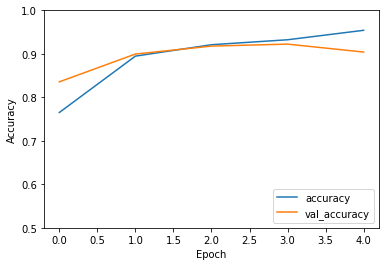

In [37]:
### CNN version
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

model=tf.keras.Sequential(
    [
        tf.keras.Input(shape=(161,99,1)),
        layers.Conv2D(32,(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64,(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64,(3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(labels))
        
     ]
)

print(model.summary())
# model=tf.keras.Sequential()
# model.add(layers.Conv2D(161, (3, 3), activation='relu', input_shape=images[0].shape))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(len(labels)))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

if len(test_images > 0):
    history = model.fit(normalized_images, classes, epochs=5, validation_data=(normalized_test_images, test_classes))
else:
    history = model.fit(normalized_images, classes, epochs=5)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [2]:
# i=0
# for img in images:
#   print(labels[int(classes[i])])
#   i=i+1
#   plt.imshow(img)
#   plt.show()

print("*****test images******")

i=0
for img in test_images:
  print(labels[int(test_classes[i])])
  
  i=i+1
  
  
  
  plt.imshow(img)
  plt.show()


*****test images******


NameError: name 'test_images' is not defined

In [8]:
print(len(test_images))

90


In [3]:
import math
def plot_image(i, predictions_array, labels,true_label, img):
  true_label, img = true_label[i], img[i]
  #plt.subplots_adjust(bottom=0.25, right=0.25, top=0.25)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label]+str(i)),
                                color=color)


def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(predictions_array)))
  plt.yticks([])
  thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def make_predictions(model, images):                                                  
  #model.summary()  
  probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
  predictions = probability_model.predict(images)
  return (probability_model,predictions)

In [12]:
labels=[]

file_path= os.path.join("D:",os.sep,"Grassland","Data","Recordings","Freedom")
spec_path= os.path.join("D:",os.sep,"Grassland","Data","Spectrograms","Freedom")
(images)=process_dir_audio(file_path,spec_path,"",labels,sampling_rate,segment_length)

TypeError: process_dir_audio() missing 1 required positional argument: 'shift'

In [9]:

#predictions on test images
  
(probability_model,predictions)=make_predictions(model,normalized_test_images)
num_cols = 2
num_rows = math.floor(len(test_images)/num_cols)
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
class_count=[0]*len(labels)
class_correct=[0]*len(labels)
classNum=0 #current index of image within the predicted class
prevClass=-1
falsePos=0
falseNeg=0
for i in range(num_images):
  guess = np.argmax(predictions[i])
  actual=test_classes[i]
  if prevClass != actual:
    classNum=-1
    prevClass=actual
  classNum+=1
  class_count[actual]+=1
  if guess==actual: 
    class_correct[test_classes[i]]+=1
  else:
    print("predicted: "+labels[guess]+", actual: "+labels[test_classes[i]]+str(classNum))
    if actual==1:
      falseNeg+=1
    elif guess==1:
      falsePos+=1

  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  #plot_image(i, predictions[i], labels,test_classes, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)


  plot_value_array(i, predictions[i], test_classes)
  
print("false positive: ",falsePos)

print("false negative: ",falseNeg)
print(class_count)
print(class_correct)
for i in range(len(labels)):
  if class_count[0] > 0:
    print(labels[i]+": "+str(class_correct[i])+" out of "+str(class_count[i])+" ("+str(class_correct[i]/class_count[i])+")")
plt.tight_layout(pad=2.0,h_pad=1.5)
plt.show()

NameError: name 'make_predictions' is not defined

In [38]:
model.save(os.path.join("D:",os.sep,"Grassland","Models","Richardson_2024_2"))

INFO:tensorflow:Assets written to: D:\Grassland\Models\Richardson_2024_2\assets


INFO:tensorflow:Assets written to: D:\Grassland\Models\Richardson_2024_2\assets


In [11]:
print(test_images)
model.summary()

[[[-23.59600638 -21.16615232 -21.16738777 ... -21.62964665 -21.16062079
   -20.22128361]
  [-23.43321947 -20.91799939 -22.79326195 ... -22.85667009 -25.01899893
   -20.66859567]
  [-22.38722563 -20.79599542 -22.65833728 ... -24.91624473 -21.05509762
   -22.61097017]
  ...
  [-20.05908039 -20.44296931 -23.01245249 ... -22.7200964  -24.9961045
   -24.42299136]
  [-21.94268485 -21.61641703 -21.98443165 ... -22.38544308 -22.91707798
   -24.03162518]
  [-21.59785469 -22.53441657 -22.24787928 ... -22.36788147 -22.94110023
   -23.14636668]]

 [[-21.66553491 -22.87811729 -23.7740826  ... -22.85871429 -22.00166878
   -21.97960697]
  [-21.7252092  -24.78224666 -23.04222751 ... -21.91810522 -21.50709303
   -22.44932907]
  [-21.83197764 -23.06475742 -22.66668546 ... -21.43651474 -21.87634457
   -22.86866832]
  ...
  [-24.54308715 -23.83300232 -24.10927264 ... -22.23823715 -23.95498243
   -21.85876364]
  [-25.34390754 -23.61664454 -22.870614   ... -22.09966325 -23.33595233
   -21.28795792]
  [-24.0

{'Sensor1': [1.5328636787002572, 88.27853964360949, 7.869518217853916], 'Sensor2': [0.29852207099306777, 14.511534704899248, 5.771443838422154], 'Sensor3': [0.9270974505243598, 115.62812959607204, 16.500842124413246], 'Sensor4': [5.275799356856899, 77.2672222116799, 26.82756380654777], 'Sensor5': [0.059391959427557754, 1.39711864543727, 4.6256786031405595], 'Sensor6': [0.583953760466202, 32.71592493833906, 15.414424178564058], 'Sensor7': [8.424222748955778, 403.27423614988527, 74.74763567014018], 'Sensor8': [1.13671712872617, 17.476965573623847, 67.20535347143503], 'Sensor9': [0.3057695659359163, 4.397973369768125, 57.09771078829726], 'Sensor10': [0.4707777421037407, 19.557776106189728, 41.07302009334949]}
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor1\20240601_090000.WAV
file length  169920000
about to make predictions on 87 images.
3/3 [==============================] - 0s 83ms/step
most likely class: 1 1.7273470155658333
most likely class: 2 3.757262587336176
most l

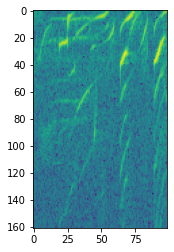

class: 0 likelihood: 0.602 total value: 3
class: 1 likelihood: 0.371 total value: 2
class: 2 likelihood: 0.027 total value: 0
most likely class: 2 2.92549948074016
most likely class: 2 2.3211848135662008
most likely class: 1 4.874259158078704
most likely class: 1 7.993059095067479
most likely class: 1 4.499532167592104
most likely class: 1 6.607899995696094
most likely class: 1 8.087255918437892
most likely class: 2 2.9954061535139522
most likely class: 1 3.4429474283719816
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor10\20240601_100000.WAV
file length  169920000
about to make predictions on 24 images.
1/1 [==============================] - 0s 152ms/step
most likely class: 1 2.4569180396930417
most likely class: 1 3.7056110578946413
most likely class: 1 5.894606201515047
most likely class: 1 3.608709173282913
most likely class: 1 6.076986035842504
most likely class: 1 4.367562096461185
most likely class: 1 5.7582567957755115
most likely class: 1 4.0049581992684615
most

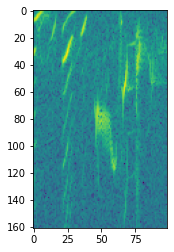

class: 0 likelihood: 0.526 total value: 2
class: 1 likelihood: 0.378 total value: 2
class: 2 likelihood: 0.096 total value: 0
most likely class: 2 3.9590375032892164
most likely class: 1 3.5457699553331605
most likely class: 1 4.171241746906412
most likely class: 1 3.903206172454867
most likely class: 2 2.7290146730735794
most likely class: 1 4.924416215459109
most likely class: 1 5.997995634273128
most likely class: 2 4.960601557973865
most likely class: 2 5.548347195337849
most likely class: 2 1.069857916743048
most likely class: 2 1.0103575172595427
most likely class: 1 3.3415669256764478
most likely class: 2 2.130551774692962
most likely class: 1 4.3104407292447515
most likely class: 1 6.201223190801163
most likely class: 2 2.7203693303228165
most likely class: 1 2.7620107056019356
most likely class: 2 3.4439935562704203
most likely class: 1 5.2843824351049475
most likely class: 1 5.558688777337833
most likely class: 1 5.722175515865919
most likely class: 1 5.4814216846709165
most 

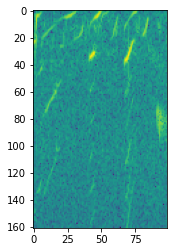

class: 0 likelihood: 0.859 total value: 3
class: 1 likelihood: 0.1 total value: 0
class: 2 likelihood: 0.041 total value: 0
most likely class: 2 6.506853623246649
most likely class: 2 5.0773674436522045
most likely class: 2 6.796444104227328
most likely class: 2 3.8558718269897967
most likely class: 2 6.9084552764576515
most likely class: 2 2.608307236291367
most likely class: 2 3.6239254408065764
most likely class: 2 4.839024681796356
most likely class: 2 4.266549096556526
most likely class: 2 5.937666645974018
most likely class: 2 5.682601363515185
most likely class: 2 3.8055949678381715
most likely class: 2 3.8461577952883634
most likely class: 2 3.921683821159938
most likely class: 2 4.764129931021785
most likely class: 2 2.9214549229620697
most likely class: 2 2.7440779521002816
most likely class: 2 5.5703070757238935
most likely class: 2 4.935451433997245
most likely class: 2 3.364075835999288
most likely class: 2 3.91880136908035
most likely class: 2 3.8055193661626663
most like

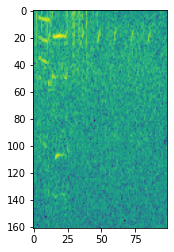

class: 0 likelihood: 0.436 total value: 2
class: 1 likelihood: 0.156 total value: 1
class: 2 likelihood: 0.408 total value: 2
most likely class: 2 1.2868441147754761
most likely class: 2 0.6672358012136256
most likely class: 2 7.961189570720275
most likely class: 2 6.701960038943459
most likely class: 2 6.23011426851493
most likely class: 2 6.259106390067961
most likely class: 2 9.07887671876327
most likely class: 2 3.517335892649848
most likely class: 2 4.101670187490129
most likely class: 2 4.340940892268713
most likely class: 2 4.081408092055973
most likely class: 2 4.151486051397194
most likely class: 2 3.981348540398088
most likely class: 2 2.7748527287483427
most likely class: 2 2.1859747627168953
most likely class: 2 5.525723915019728
most likely class: 2 6.357075157906973
most likely class: 2 9.015563616613903
most likely class: 2 5.32330799342035
most likely class: 2 3.58283474619356
most likely class: 2 4.023097895669031
most likely class: 2 2.9967672311926283
most likely cla

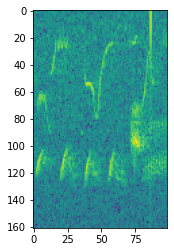

class: 0 likelihood: 0.363 total value: 0
class: 1 likelihood: 0.294 total value: 0
class: 2 likelihood: 0.343 total value: 0
most likely class: 2 7.032548963114279
most likely class: 1 4.725116680324172
most likely class: 2 4.802137522301627
most likely class: 1 6.324335659803779
most likely class: 1 2.0835559790323392
most likely class: 2 14.039516737626036
most likely class: 2 1.0347529493882552
most likely class: 1 1.5435464411335091
most likely class: 2 2.9748393215362072
most likely class: 2 0.5957443340306114
most likely class: 1 3.2773003892167103
most likely class: 2 7.712167153933971
most likely class: 1 4.6350774125634855
most likely class: 1 3.744602788738835
most likely class: 2 3.643299401720016
most likely class: 2 2.822012417895289
most likely class: 0 4.838024739511361


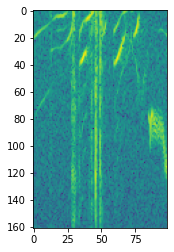

class: 0 likelihood: 0.658 total value: 3
class: 1 likelihood: 0.305 total value: 1
class: 2 likelihood: 0.038 total value: 0
most likely class: 1 2.6575568458988568
most likely class: 1 2.2804137874924506
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor3\20240601_120000.WAV
file length  169920000
about to make predictions on 101 images.
4/4 [==============================] - 0s 60ms/step
most likely class: 2 0.848992978039519
most likely class: 2 0.7960284261510014
most likely class: 2 7.290271660849362
most likely class: 2 2.7916431177100023
most likely class: 2 3.2578203399310013
most likely class: 2 8.364492924376037
most likely class: 2 0.4812379684585326
most likely class: 1 3.229226773530032
most likely class: 1 5.56039275313201
most likely class: 1 5.469985155879487
most likely class: 1 4.166918553112334
most likely class: 1 4.40450813702386
most likely class: 1 5.7651797375641385
most likely class: 1 5.648920407071336
most likely class: 1 4.800240288601454
most l

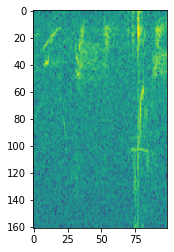

class: 0 likelihood: 0.728 total value: 1
class: 1 likelihood: 0.081 total value: 0
class: 2 likelihood: 0.191 total value: 0
most likely class: 1 3.5808936199368424
most likely class: 1 3.085143545934342
most likely class: 1 1.5492329886095222
most likely class: 2 1.685116222493796
most likely class: 0 5.283129471655046


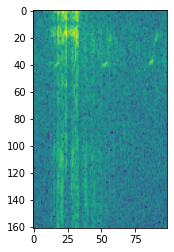

class: 0 likelihood: 0.565 total value: 3
class: 1 likelihood: 0.305 total value: 2
class: 2 likelihood: 0.13 total value: 1
most likely class: 1 3.2748835496148474
most likely class: 1 3.0662458148522727
most likely class: 2 3.2465371943346883
most likely class: 1 4.779979302238238
most likely class: 2 3.0434568032739397
most likely class: 1 4.214496596484564
most likely class: 2 1.5372410788090707
most likely class: 1 2.7084976780489463
most likely class: 2 3.217379764880106
most likely class: 2 1.694512763126986
most likely class: 2 1.012791709946937
most likely class: 2 1.7896312208949305
most likely class: 2 3.938398154935133
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor4\20240601_100000.WAV
file length  169920000
about to make predictions on 43 images.
2/2 [==============================] - 0s 33ms/step
most likely class: 1 8.254345746080935
most likely class: 1 6.0259747596865125
most likely class: 2 41.11485084066724
most likely class: 1 56.329301234608124
most

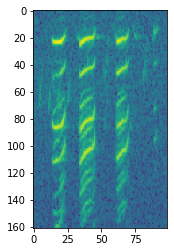

class: 0 likelihood: 1.0 total value: 11
class: 1 likelihood: 0.0 total value: 0
class: 2 likelihood: 0.0 total value: 0
most likely class: 0 8.404308493839098


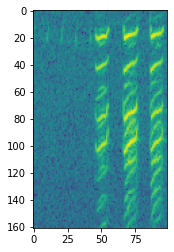

class: 0 likelihood: 1.0 total value: 8
class: 1 likelihood: 0.0 total value: 0
class: 2 likelihood: 0.0 total value: 0
most likely class: 0 6.759013342763594


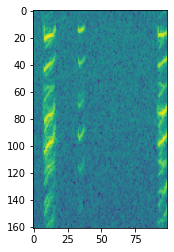

class: 0 likelihood: 0.972 total value: 7
class: 1 likelihood: 0.026 total value: 0
class: 2 likelihood: 0.002 total value: 0
most likely class: 0 10.207240583426191


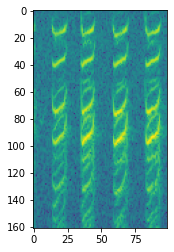

class: 0 likelihood: 1.0 total value: 10
class: 1 likelihood: 0.0 total value: 0
class: 2 likelihood: 0.0 total value: 0
most likely class: 0 13.701362103258457


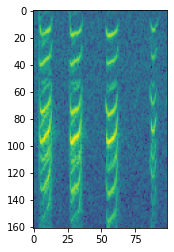

class: 0 likelihood: 0.981 total value: 13
class: 1 likelihood: 0.017 total value: 0
class: 2 likelihood: 0.002 total value: 0
most likely class: 0 4.085086868446175


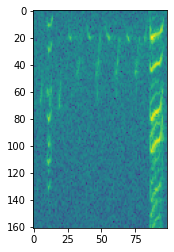

class: 0 likelihood: 0.515 total value: 2
class: 1 likelihood: 0.468 total value: 2
class: 2 likelihood: 0.017 total value: 0
most likely class: 2 4.448577316234632
most likely class: 0 6.2640020070416425


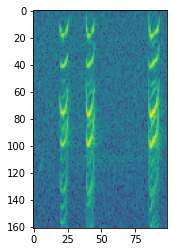

class: 0 likelihood: 0.909 total value: 6
class: 1 likelihood: 0.064 total value: 0
class: 2 likelihood: 0.027 total value: 0
most likely class: 1 8.475392055238839
most likely class: 2 4.780204989203329
most likely class: 2 2.9006032003665125
most likely class: 2 4.298015194057335
most likely class: 2 2.6565073852797867
most likely class: 2 11.029230220403106
most likely class: 2 0.7043737766218012
most likely class: 2 22.615804020807584
most likely class: 2 3.4725804025629294
most likely class: 1 10.093315434678562
most likely class: 2 2.3105818354040792
most likely class: 1 7.191939723706602
most likely class: 2 2.449979765591644
most likely class: 1 9.401182454601296
most likely class: 2 5.929926981522271
most likely class: 2 2.1044385104403545
most likely class: 2 9.346566564510889
most likely class: 2 4.327596603232591
most likely class: 2 0.48486264450630717
most likely class: 2 1.908065251608384
most likely class: 2 3.940174719090472
most likely class: 2 6.297899182521578
most 

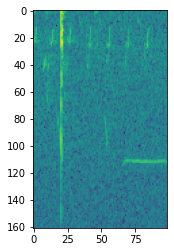

class: 0 likelihood: 0.373 total value: 1
class: 1 likelihood: 0.318 total value: 1
class: 2 likelihood: 0.309 total value: 1
most likely class: 2 6.045572131976966
most likely class: 1 3.8636290518547582
most likely class: 1 4.482660675855915
most likely class: 2 3.887520834814829
most likely class: 2 1.2714109509446687
most likely class: 1 4.664456085410671
most likely class: 2 6.67525866289485
most likely class: 2 6.035959108893147
most likely class: 2 5.814857716862635
most likely class: 2 3.295784261633211
most likely class: 2 5.545326806318951
most likely class: 2 1.374470450627056
most likely class: 2 3.4169576356421385
most likely class: 2 4.872028298272342
most likely class: 2 4.433212467427115
most likely class: 2 1.4994107991588401
most likely class: 2 9.996483950398591
most likely class: 2 3.4640099574269527
most likely class: 2 4.415377347942809
most likely class: 2 7.647426668717998
most likely class: 1 9.483723958884356
most likely class: 2 3.614609392006474
most likely 

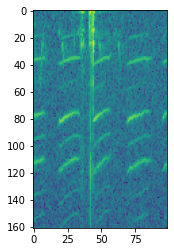

class: 0 likelihood: 0.996 total value: 4
class: 1 likelihood: 0.001 total value: 0
class: 2 likelihood: 0.003 total value: 0
most likely class: 1 8.61901364307495
most likely class: 2 9.114431887872767
most likely class: 0 13.846681226030357


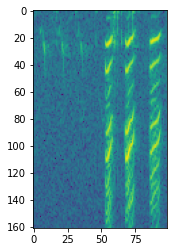

class: 0 likelihood: 0.926 total value: 13
class: 1 likelihood: 0.071 total value: 1
class: 2 likelihood: 0.003 total value: 0
most likely class: 0 28.088267183873263


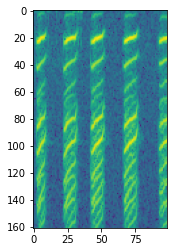

class: 0 likelihood: 1.0 total value: 28
class: 1 likelihood: 0.0 total value: 0
class: 2 likelihood: 0.0 total value: 0
most likely class: 0 6.5536336892830045


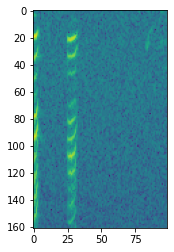

class: 0 likelihood: 0.663 total value: 4
class: 1 likelihood: 0.031 total value: 0
class: 2 likelihood: 0.307 total value: 2
most likely class: 2 2.5915704865820155
most likely class: 2 3.1712518125917657
most likely class: 2 3.9372436858901034
most likely class: 1 7.185822207152114
most likely class: 0 33.45501908225498


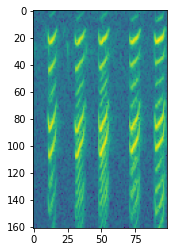

class: 0 likelihood: 1.0 total value: 33
class: 1 likelihood: 0.0 total value: 0
class: 2 likelihood: 0.0 total value: 0
most likely class: 0 28.357319783731054


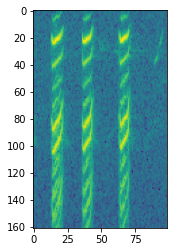

class: 0 likelihood: 1.0 total value: 28
class: 1 likelihood: 0.0 total value: 0
class: 2 likelihood: 0.0 total value: 0
most likely class: 1 7.13095794756926
most likely class: 0 4.766455932585536


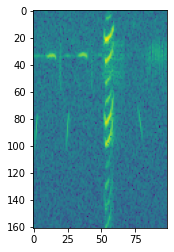

class: 0 likelihood: 0.853 total value: 4
class: 1 likelihood: 0.125 total value: 1
class: 2 likelihood: 0.022 total value: 0
most likely class: 1 6.67161867290884
most likely class: 1 6.419763193180053
most likely class: 2 0.5573675044248283
most likely class: 1 0.9167874379844606
most likely class: 2 2.3885692385677713
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor4\20240601_130000.WAV
file length  169920000
about to make predictions on 141 images.
5/5 [==============================] - 0s 60ms/step
most likely class: 1 6.695293606622405
most likely class: 2 4.639477893269894
most likely class: 2 12.511640624386882
most likely class: 2 22.699965933754523
most likely class: 2 29.263872739473207
most likely class: 1 55.84819713042813
most likely class: 1 18.74727638226953
most likely class: 2 6.0400407785738555
most likely class: 2 2.0390409472119355
most likely class: 2 7.063671212881132
most likely class: 2 5.70683657766515
most likely class: 1 6.07228932754882
most l

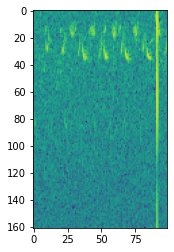

class: 0 likelihood: 0.515 total value: 1
class: 1 likelihood: 0.295 total value: 0
class: 2 likelihood: 0.189 total value: 0
most likely class: 2 1.5017229168549018
most likely class: 2 0.47245984686433484
most likely class: 2 1.270835656772376
most likely class: 2 0.6286109562774991
most likely class: 2 1.6381677365281737
most likely class: 2 0.9621238750769864
most likely class: 2 1.7969432781557197
most likely class: 2 1.6476377591279838
most likely class: 2 2.6881364746889327
most likely class: 2 5.626174907949025
most likely class: 2 1.3706389179503726
most likely class: 2 1.8407910673514984
most likely class: 2 1.9442686172740626
most likely class: 2 3.8708573288661623
most likely class: 1 4.187947388247308
most likely class: 2 0.9894165507633991
most likely class: 2 3.6450471995811706
most likely class: 2 0.6661894073742647
most likely class: 2 3.15969127731321
most likely class: 2 2.120043015950706
most likely class: 2 2.3056535106612985
most likely class: 2 6.006231617828095


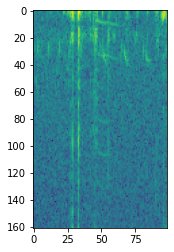

class: 0 likelihood: 0.423 total value: 2
class: 1 likelihood: 0.314 total value: 2
class: 2 likelihood: 0.263 total value: 1
most likely class: 1 26.919314137192526
most likely class: 1 45.83512858841404
most likely class: 1 24.583040643719418
most likely class: 2 4.969557887839374
most likely class: 1 31.761669858612905
most likely class: 1 40.44931263489099
most likely class: 1 19.936917813315297
most likely class: 1 16.213097474128947
most likely class: 1 34.98053176880596
most likely class: 1 41.02703050076183
most likely class: 2 15.42143402358681
most likely class: 1 18.530384836754155
most likely class: 1 43.43740943700497
most likely class: 1 28.58083328236977
most likely class: 1 22.836608920058033
most likely class: 1 23.450382529740846
most likely class: 1 26.79322457008919
most likely class: 1 32.59671066890071
most likely class: 1 37.44410321162812
most likely class: 1 24.330312106455953
most likely class: 1 29.96755473348324
most likely class: 2 13.910711130925913
most l

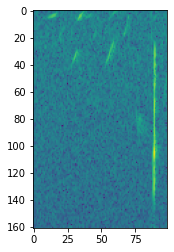

class: 0 likelihood: 0.444 total value: 1
class: 1 likelihood: 0.298 total value: 1
class: 2 likelihood: 0.258 total value: 1
most likely class: 2 2.4978250132113304
most likely class: 2 2.511906940861507
most likely class: 2 3.190523343832319
most likely class: 2 2.4531972228719945
most likely class: 2 2.2228527589792573
most likely class: 2 2.354359979252169
most likely class: 2 2.51696506102144
most likely class: 2 2.5540648732981803
most likely class: 2 2.3182994305317566
most likely class: 2 2.6376832676117834
most likely class: 2 2.053557848020076
most likely class: 2 2.515370524349194
most likely class: 2 2.581134355241408
most likely class: 2 2.765383982157769
most likely class: 2 1.886951479073418
most likely class: 2 2.9279612695991917
most likely class: 2 2.653852622606565
most likely class: 2 2.1330993493506725
most likely class: 2 2.5830288862728032
most likely class: 2 2.324701853239386
most likely class: 2 2.980552392969585
most likely class: 2 2.563128828896037
most lik

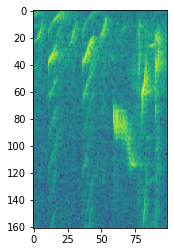

class: 0 likelihood: 0.687 total value: 5
class: 1 likelihood: 0.263 total value: 2
class: 2 likelihood: 0.05 total value: 0
most likely class: 1 9.576475587104012
most likely class: 1 3.6989757179559217
most likely class: 1 6.86000398597051
most likely class: 1 11.718978677743683
most likely class: 1 5.288443353044814
most likely class: 1 9.145621667571769
most likely class: 1 7.3657617002115545
most likely class: 1 10.472446924977225
most likely class: 1 7.077917894776586
most likely class: 1 6.9876969852456705
most likely class: 1 7.004728024316257
most likely class: 1 3.1866258684542066
most likely class: 2 5.087287003593364
most likely class: 1 5.529022684814467
most likely class: 1 7.844771013593395
most likely class: 1 3.660852260732885
most likely class: 1 6.649332665289628
most likely class: 1 8.027398223065626
most likely class: 1 6.833567692203367
most likely class: 1 4.8695357801574515
most likely class: 1 9.136911314141534
most likely class: 1 7.095555428567232
most likely

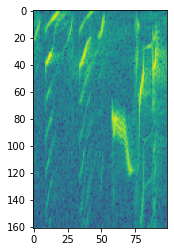

class: 0 likelihood: 0.689 total value: 6
class: 1 likelihood: 0.296 total value: 3
class: 2 likelihood: 0.015 total value: 0
most likely class: 1 12.047597123958232
most likely class: 1 8.231267693805341
most likely class: 1 12.787727652479674
most likely class: 1 10.704189703099663
most likely class: 1 4.333700020948281
most likely class: 1 6.485921840412183
most likely class: 1 6.514571889211153
most likely class: 1 9.068748501203908
most likely class: 1 6.093458964278464
most likely class: 1 5.139561020174584
most likely class: 1 7.011576977707114
most likely class: 1 5.831994340435517
most likely class: 1 6.314167528776354
most likely class: 1 8.82622278389385
most likely class: 1 11.700181932834113
most likely class: 1 9.545501708252624
most likely class: 1 11.18396426902682
most likely class: 1 3.7765512537482997
most likely class: 1 4.85298997481022
most likely class: 1 9.17370847068073
most likely class: 1 12.853792218478523
most likely class: 1 6.705160851083532
most likely c

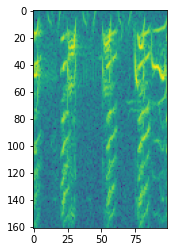

class: 0 likelihood: 0.922 total value: 7
class: 1 likelihood: 0.065 total value: 0
class: 2 likelihood: 0.013 total value: 0
most likely class: 0 8.599324792402353


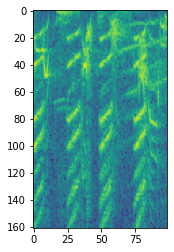

class: 0 likelihood: 0.999 total value: 9
class: 1 likelihood: 0.0 total value: 0
class: 2 likelihood: 0.0 total value: 0
most likely class: 0 6.857260870761463


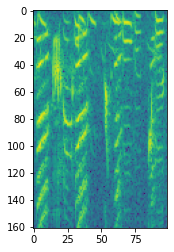

class: 0 likelihood: 0.983 total value: 7
class: 1 likelihood: 0.014 total value: 0
class: 2 likelihood: 0.003 total value: 0
most likely class: 1 3.2939869934303965
most likely class: 1 6.625439907386272
most likely class: 1 6.691958040926263
most likely class: 1 4.606676883752131
most likely class: 1 2.4643558857817096
most likely class: 2 3.388235812616975
most likely class: 1 4.484257188210595
most likely class: 1 5.31970703167493
most likely class: 1 6.447231136984976
most likely class: 1 3.715965137717159
most likely class: 2 3.6599475877197647
most likely class: 1 6.311298264159964
most likely class: 1 5.808622199744361
most likely class: 1 4.209067202348304
most likely class: 1 4.7664651069655575
most likely class: 1 5.876234802542355
most likely class: 1 2.1118666546968012
most likely class: 1 2.230092628010551
most likely class: 1 3.452139192377253
most likely class: 1 3.8119663393650294
most likely class: 1 3.2174527810227342
most likely class: 1 2.7009873237508586
most like

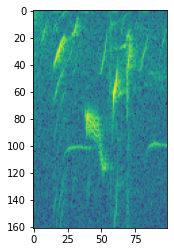

class: 0 likelihood: 0.632 total value: 2
class: 1 likelihood: 0.289 total value: 1
class: 2 likelihood: 0.079 total value: 0
most likely class: 1 3.5713250412926727
most likely class: 1 4.28149868565264
most likely class: 1 3.3667557655603724
most likely class: 1 4.045376809741881
most likely class: 1 3.5102064084638718
most likely class: 1 4.116067707379923
most likely class: 1 3.2165250756017376
most likely class: 1 3.9627593229284
most likely class: 1 2.8792400543463197
most likely class: 1 2.9457319521280705
most likely class: 1 2.44294112499899
most likely class: 1 2.4405857517506306
most likely class: 1 3.8376522499777455
most likely class: 1 3.9614869509976773
most likely class: 1 4.234018651063522
most likely class: 1 3.8522133909543164
most likely class: 1 3.815595798840542
most likely class: 1 2.5880231198995647
most likely class: 1 1.9635115398185687
most likely class: 2 2.284771463406597
most likely class: 1 3.091139863355807
most likely class: 1 3.42342156440677
most like

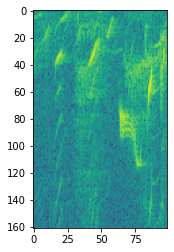

class: 0 likelihood: 0.836 total value: 4
class: 1 likelihood: 0.055 total value: 0
class: 2 likelihood: 0.109 total value: 1
most likely class: 1 8.379808180511912
most likely class: 1 4.513586112412205
most likely class: 2 2.700920681158472
most likely class: 2 6.646931801341631
most likely class: 1 58.22246565833979
most likely class: 1 91.8031150959288
most likely class: 1 92.1288770984339
most likely class: 1 28.920721245460694
most likely class: 1 5.170894112013322
most likely class: 1 5.541816059456322
most likely class: 1 3.686575872035737
most likely class: 1 2.7616094870448022
most likely class: 1 7.646820616789358
most likely class: 1 5.6092420173066175
most likely class: 1 7.1409568943603805
most likely class: 1 4.5859790333844295
most likely class: 2 4.450751447238848
most likely class: 1 2.5018981299211442
most likely class: 2 3.5798145268425334
most likely class: 1 3.527798701330165
most likely class: 1 3.69312108036178
most likely class: 1 6.8135940564317545
most likely

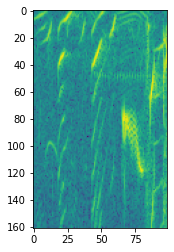

class: 0 likelihood: 0.483 total value: 4
class: 1 likelihood: 0.401 total value: 3
class: 2 likelihood: 0.116 total value: 1
most likely class: 1 6.568768158263385
most likely class: 2 0.8291108071358856
most likely class: 1 9.756682794109961
most likely class: 2 2.5046566730986117
most likely class: 1 9.163604289347171
most likely class: 1 2.2233180680672384
most likely class: 2 2.970190058148085
most likely class: 2 4.618609615636023
most likely class: 1 7.202416979874892
most likely class: 1 3.2505455967573336
most likely class: 1 13.147412625267746
most likely class: 1 2.571774125844066
most likely class: 1 4.458737348964877
most likely class: 1 7.0595681151833745
most likely class: 1 6.100337675391447
most likely class: 1 2.628717014826665
most likely class: 1 6.449729877445612
most likely class: 1 2.8738928845248837
most likely class: 1 3.1121460298436316
most likely class: 1 6.286975981611763
most likely class: 1 5.476647565880974
most likely class: 1 3.3366445833632548
most li

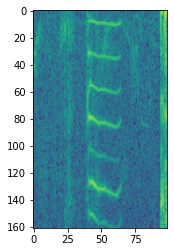

class: 0 likelihood: 0.476 total value: 15
class: 1 likelihood: 0.43 total value: 13
class: 2 likelihood: 0.094 total value: 3
most likely class: 1 91.11920509603273
most likely class: 1 104.97928398889867
most likely class: 1 104.7012242653026
most likely class: 1 45.54513015648938
most likely class: 1 9.181913967096783
most likely class: 1 11.910045600275783
most likely class: 1 8.914940262849903
most likely class: 1 6.746500375955763
most likely class: 1 7.886916570227794
most likely class: 1 35.17878572565483
most likely class: 1 97.05143872598954
most likely class: 1 98.69501214854847
most likely class: 1 78.63711039390458
most likely class: 1 8.951076903995322
most likely class: 1 27.34756436841307
most likely class: 1 31.350357658146404
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor7\20240601_120000.WAV
file length  169920000
about to make predictions on 405 images.
13/13 [==============================] - 1s 77ms/step
most likely class: 1 9.860661182593702
most 

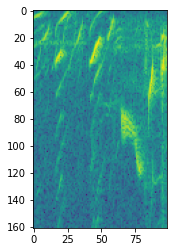

class: 0 likelihood: 0.752 total value: 5
class: 1 likelihood: 0.187 total value: 1
class: 2 likelihood: 0.061 total value: 0
most likely class: 1 9.819977620601373
most likely class: 1 9.255640905387464
most likely class: 1 8.309112062213332
most likely class: 1 7.455043898144856
most likely class: 1 8.09153635100309
most likely class: 1 2.9647638603235253
most likely class: 1 6.068212607137156
most likely class: 1 9.21139247245236
most likely class: 1 12.560068568305166
most likely class: 1 5.772263258613235
most likely class: 1 9.845131850842321
most likely class: 1 7.298823789953057
most likely class: 1 10.041951283895864
most likely class: 1 7.017653042910686
most likely class: 1 6.699815248049522
most likely class: 1 9.952248425927042
most likely class: 1 6.100581668786927
most likely class: 1 7.986077129205619
most likely class: 1 11.567141072294282
most likely class: 1 1.9755842868366218
most likely class: 1 1.9811172103248667
most likely class: 1 3.8028882951400367
most likely

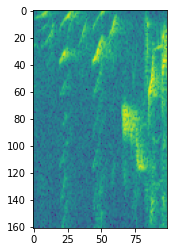

class: 0 likelihood: 0.733 total value: 5
class: 1 likelihood: 0.169 total value: 1
class: 2 likelihood: 0.098 total value: 1
most likely class: 1 12.924260495931906
most likely class: 1 14.902971506801887
most likely class: 1 25.248975993034215
most likely class: 1 12.93008384802997
most likely class: 1 7.092955787913969
most likely class: 1 4.4763108247434
most likely class: 1 3.5913117236934795
most likely class: 1 4.714093550108662
most likely class: 1 4.417151649277829
most likely class: 1 5.406659169110504
most likely class: 1 4.376668860925638
most likely class: 1 6.418766624192711
most likely class: 1 7.393723972893265
most likely class: 1 4.276668623222346
most likely class: 1 6.726262239019424
most likely class: 1 3.7937703017393885
most likely class: 1 6.437737718103215
most likely class: 1 4.664083575635606
most likely class: 1 3.846011759451464
most likely class: 1 3.8572088022174245
most likely class: 1 5.760286564551282
most likely class: 1 4.746528755962665
most likely 

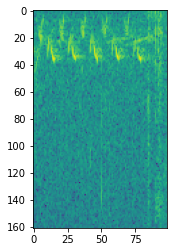

class: 0 likelihood: 0.683 total value: 4
class: 1 likelihood: 0.116 total value: 1
class: 2 likelihood: 0.201 total value: 1
most likely class: 1 23.621074732926886
most likely class: 1 92.28201400805384
most likely class: 1 82.43285339454401
most likely class: 1 28.5859948972768
most likely class: 1 92.07749796408716
most likely class: 1 91.10280383104214
most likely class: 1 22.22302870952519
most likely class: 2 68.10784584990955
most likely class: 1 102.98217731896942
most likely class: 1 97.00770363944521
most likely class: 1 107.04949990793942
most likely class: 1 88.54124244700395
most likely class: 1 3.9083473807100586
most likely class: 2 7.696541068778681
most likely class: 1 62.08923491329158
most likely class: 1 91.60288593725537
most likely class: 1 108.55267514399978
most likely class: 1 98.84631064000708
most likely class: 1 97.65845061008552
most likely class: 1 95.75588766537084
most likely class: 2 3.620951762779755
most likely class: 1 7.689926197221775
most likely 

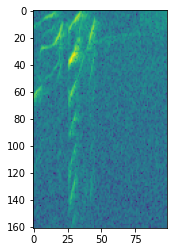

class: 0 likelihood: 0.588 total value: 3
class: 1 likelihood: 0.069 total value: 0
class: 2 likelihood: 0.343 total value: 2
most likely class: 1 6.228484251159236
most likely class: 1 8.510232724793692
most likely class: 1 6.02122239159435
most likely class: 1 5.645829382618059
most likely class: 1 2.8707581839742753
most likely class: 1 3.228925186275221
most likely class: 1 8.569232611400052
most likely class: 1 12.912460449392789
most likely class: 1 8.746375453732549
most likely class: 1 4.705390506309515
most likely class: 1 6.014253278105668
most likely class: 1 7.704634411380306
most likely class: 1 10.81619797434099
most likely class: 1 8.19125722293424
most likely class: 1 7.73973259754098
most likely class: 1 7.920103371841826
most likely class: 1 19.232282329627196
most likely class: 1 38.46220867408088
most likely class: 1 22.980547560153536
most likely class: 1 3.757279690880811
most likely class: 1 4.481329136774667
most likely class: 1 4.679784490777483
most likely cla

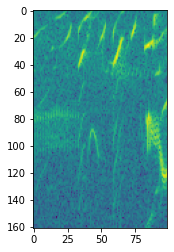

class: 0 likelihood: 0.574 total value: 2
class: 1 likelihood: 0.424 total value: 2
class: 2 likelihood: 0.002 total value: 0
most likely class: 1 4.928526058304649
most likely class: 1 11.660861204592715
most likely class: 1 16.10956692511914
most likely class: 1 6.241439079056753
most likely class: 1 8.280289238965173
most likely class: 1 7.404267380846107
most likely class: 2 3.3849774464695552
most likely class: 2 3.9385243435871518
most likely class: 2 3.814529325526894
most likely class: 0 6.56613360404277


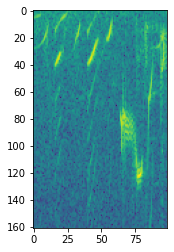

class: 0 likelihood: 0.917 total value: 6
class: 1 likelihood: 0.038 total value: 0
class: 2 likelihood: 0.045 total value: 0
most likely class: 1 5.532410928746611
most likely class: 2 4.482784612996207
most likely class: 1 5.893118783353136
most likely class: 1 4.895948981897969
most likely class: 1 4.914479304143039
most likely class: 1 5.078430716867179
most likely class: 1 4.196904441480093
most likely class: 2 3.500687821504053
most likely class: 2 2.5163492089927053
most likely class: 2 5.860374062718552
most likely class: 1 5.120687394420264
most likely class: 2 3.3131311488427317
most likely class: 1 4.4082879821830865
most likely class: 1 4.164066062522244
most likely class: 1 3.253746090596093
most likely class: 1 4.5619353465894275
most likely class: 2 7.614865582425435
most likely class: 2 6.399466405005685
most likely class: 2 7.093839078779252
most likely class: 2 6.414948582355946
most likely class: 0 4.719034774801105


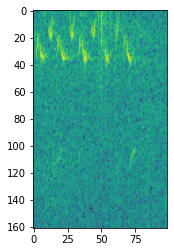

class: 0 likelihood: 0.649 total value: 3
class: 1 likelihood: 0.05 total value: 0
class: 2 likelihood: 0.301 total value: 1
most likely class: 2 4.959174589281661
most likely class: 2 6.526004237831368
most likely class: 1 3.8609246574764873
most likely class: 1 3.50137613828086
most likely class: 1 5.284855341327775
most likely class: 2 5.203733743052004
most likely class: 2 10.55758771609084
most likely class: 2 9.470673825233797
most likely class: 2 7.288583201440354
most likely class: 2 4.1661653491771755
most likely class: 2 3.3381336156078247
most likely class: 2 5.106764278966117
most likely class: 2 9.067725964884795
most likely class: 2 6.317887531067206
most likely class: 2 7.801286988418796
most likely class: 2 8.664917538249764
most likely class: 2 5.572330043271954
most likely class: 2 4.504913039615653
most likely class: 2 7.510237350331533
most likely class: 2 8.486392577939505
most likely class: 2 4.907765112025385
most likely class: 2 3.4465317716336803
most likely cl

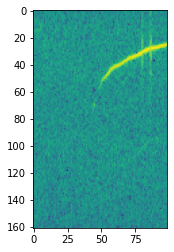

class: 0 likelihood: 0.583 total value: 2
class: 1 likelihood: 0.39 total value: 2
class: 2 likelihood: 0.027 total value: 0
most likely class: 1 2.6708199010038602
most likely class: 0 1.8029780845667402


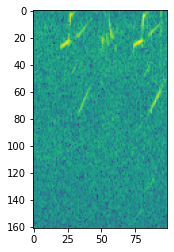

class: 0 likelihood: 0.683 total value: 1
class: 1 likelihood: 0.071 total value: 0
class: 2 likelihood: 0.245 total value: 0
most likely class: 2 1.84903932475736
most likely class: 2 2.6936873228709493
most likely class: 2 5.424421543424811
most likely class: 2 4.377256720796197
most likely class: 2 3.7321350147364916
most likely class: 2 4.450633066720252
most likely class: 2 6.699063573644364
most likely class: 2 9.580277344861392
most likely class: 2 10.595393700014979
most likely class: 2 6.7911864881274795
most likely class: 2 6.243947864444126
most likely class: 2 5.631173434630735
most likely class: 2 3.785967406904754
most likely class: 2 4.507583144582639
most likely class: 2 4.326995767927549
most likely class: 2 4.8452877814582855
most likely class: 1 4.105253831916497
most likely class: 1 5.484475785603653
most likely class: 1 4.068849990822999
most likely class: 2 5.025300698785984
most likely class: 2 4.62131788493402
most likely class: 2 4.012140133056164
most likely c

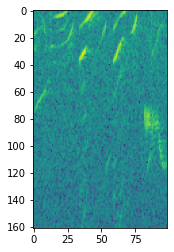

class: 0 likelihood: 0.72 total value: 3
class: 1 likelihood: 0.254 total value: 1
class: 2 likelihood: 0.026 total value: 0
most likely class: 1 4.647397514619096
most likely class: 2 4.388036551409642
most likely class: 2 4.2127859055498735
most likely class: 2 7.027711590355255
most likely class: 2 7.435212725512739
most likely class: 2 5.420433095586738
most likely class: 1 3.4646278621050373
most likely class: 1 3.0046019627448852
most likely class: 2 3.6451897989556747
most likely class: 2 5.815356257397054
most likely class: 2 7.486653090183294
most likely class: 2 6.830031696829379
most likely class: 1 8.700767294043711
most likely class: 1 5.1930987636837065
most likely class: 2 3.346858387020074
most likely class: 0 4.305366566183832


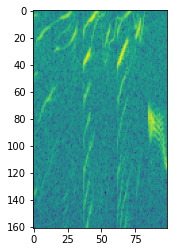

class: 0 likelihood: 0.832 total value: 4
class: 1 likelihood: 0.165 total value: 1
class: 2 likelihood: 0.003 total value: 0
most likely class: 1 9.61765541776167
most likely class: 1 8.767902965385119
most likely class: 1 12.46188000897144
most likely class: 1 10.841866827369566
most likely class: 1 14.992667824116136
most likely class: 1 11.76173019998532
most likely class: 1 16.26092749121727
most likely class: 1 8.64380708410426
most likely class: 1 30.168596553518448
most likely class: 1 81.05080909870205
most likely class: 1 115.3568439891526
most likely class: 2 2.3764294664215897
most likely class: 2 3.6236603275367405
most likely class: 2 7.610323275228762
most likely class: 2 5.302606364719555
most likely class: 2 4.914692268950041
most likely class: 2 4.436048770835361
most likely class: 2 8.06808992137696
most likely class: 2 11.071142008131954
most likely class: 2 9.009891141868518
most likely class: 2 3.8830642269603657
most likely class: 1 4.6748847998390115
most likely

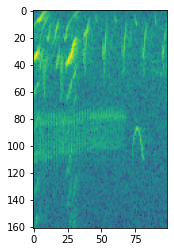

class: 0 likelihood: 0.725 total value: 3
class: 1 likelihood: 0.093 total value: 0
class: 2 likelihood: 0.182 total value: 1
most likely class: 1 23.649660119511257
most likely class: 1 85.79192337855858
most likely class: 1 112.8201413452297
most likely class: 1 62.02249436151514
most likely class: 1 19.352550547181025
most likely class: 2 74.30131073082264
most likely class: 1 105.0860580594732
most likely class: 1 103.23431599780356
most likely class: 1 95.88676322241695
most likely class: 1 111.59670813668822
most likely class: 2 58.15950905519486
most likely class: 1 6.416496633835136
most likely class: 1 10.494002054656717
most likely class: 1 5.674957335373174
most likely class: 1 5.264183895884468
most likely class: 1 7.269521546959487
most likely class: 2 8.631061368528648
most likely class: 2 5.649684519463529
most likely class: 1 3.3448807185212734
most likely class: 1 7.3918392958621
most likely class: 1 10.738840826461589
most likely class: 1 6.108576603981394
most likely

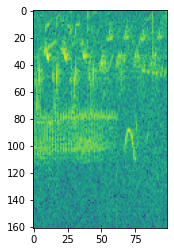

class: 0 likelihood: 0.448 total value: 2
class: 1 likelihood: 0.273 total value: 1
class: 2 likelihood: 0.279 total value: 1
most likely class: 1 7.66281951835185
most likely class: 2 4.966399485741138
most likely class: 2 1.9730572887713016
most likely class: 2 7.072203868919231
most likely class: 2 8.334106283612648
most likely class: 2 13.340053139142134
most likely class: 2 15.4890164811125
most likely class: 2 7.151373572609112
most likely class: 2 2.347882909274365
most likely class: 2 3.1624476618238346
most likely class: 2 5.393412595493777
most likely class: 0 3.8511608349101816


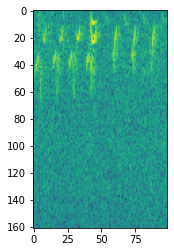

class: 0 likelihood: 0.47 total value: 2
class: 1 likelihood: 0.19 total value: 1
class: 2 likelihood: 0.34 total value: 1
most likely class: 2 3.4969847707824337
most likely class: 2 2.910902608460403
most likely class: 2 2.459075183721775
most likely class: 2 2.7203914113926997
most likely class: 2 3.470195753706036
most likely class: 2 2.8542242683005528
most likely class: 2 1.6812794058716014
most likely class: 2 2.5036382394114955
most likely class: 2 2.2571501605973645
most likely class: 2 3.0597456529638287
most likely class: 2 8.109329327955885
most likely class: 2 6.001259781491529
most likely class: 2 2.1913322380558675
most likely class: 2 4.1687709726547055
most likely class: 2 4.416171562443933
most likely class: 2 3.5719233891737927
most likely class: 2 4.025228171214686
most likely class: 2 2.64178730158303
most likely class: 2 2.0389779000709503
most likely class: 2 2.5494718668629908
most likely class: 1 2.8506225111164727
most likely class: 2 2.923303629866079
most li

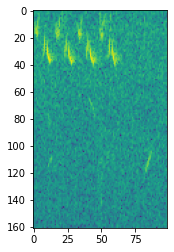

class: 0 likelihood: 0.443 total value: 2
class: 1 likelihood: 0.132 total value: 0
class: 2 likelihood: 0.425 total value: 2
most likely class: 2 6.33020849124559
most likely class: 2 4.2916995101710915
most likely class: 2 5.374288311544309
most likely class: 2 10.625073549948699
most likely class: 2 13.028886289257315
most likely class: 2 4.407384633137928
most likely class: 2 9.934739470975224
most likely class: 2 8.250500879144338
most likely class: 2 10.016430674729106
most likely class: 2 8.211618238150068
most likely class: 2 5.850555268138664
most likely class: 2 5.573436077295265
most likely class: 2 5.03833426704423
most likely class: 2 3.286516010648729
most likely class: 2 2.973737740035649
most likely class: 0 3.2920113994124924


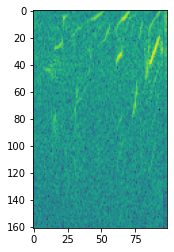

class: 0 likelihood: 0.695 total value: 2
class: 1 likelihood: 0.263 total value: 1
class: 2 likelihood: 0.042 total value: 0
most likely class: 2 5.566304009318436
most likely class: 2 3.368773939799818
most likely class: 2 5.986793385560898
most likely class: 2 4.294793272218116
most likely class: 2 7.071033253340881
most likely class: 2 5.212543033336026
most likely class: 2 6.531664063978143
most likely class: 2 14.453502453437459
most likely class: 2 8.51789118727885
most likely class: 2 4.5964390849967405
most likely class: 2 6.42883422302507
most likely class: 2 5.91337477862932
most likely class: 2 3.7316342685101853
most likely class: 2 5.362909333728319
most likely class: 2 3.135515897456927
most likely class: 2 4.230753236651225
most likely class: 2 1.8443521429640823
most likely class: 1 2.9559825939464615
most likely class: 1 2.50224626571136
most likely class: 1 5.802983542504381
most likely class: 1 11.38525692486174
most likely class: 1 17.27893689255874
most likely cla

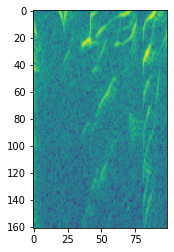

class: 0 likelihood: 0.846 total value: 4
class: 1 likelihood: 0.129 total value: 1
class: 2 likelihood: 0.025 total value: 0
most likely class: 1 3.60578617125056
most likely class: 2 3.00595350362891
most likely class: 2 6.358550069102703
most likely class: 2 6.499921000870584
most likely class: 2 3.118182840239975
most likely class: 2 4.772360145627768
most likely class: 2 6.865119028139858
most likely class: 2 5.813582737698189
most likely class: 2 4.831878008702292
most likely class: 2 11.755120658860942
most likely class: 2 10.638803831139663
most likely class: 2 5.2379509250446645
most likely class: 2 3.1085298507732784
most likely class: 2 2.960540891338794
most likely class: 1 3.4578278254218047
most likely class: 2 2.119363150141987
most likely class: 2 3.766820856702592
most likely class: 2 2.214843941113297
most likely class: 2 2.1452618706703115
most likely class: 2 4.140323916320961
most likely class: 2 7.2023090541193
most likely class: 2 2.779211169152524
most likely cl

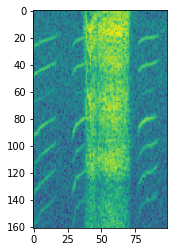

class: 0 likelihood: 0.998 total value: 7
class: 1 likelihood: 0.001 total value: 0
class: 2 likelihood: 0.001 total value: 0
most likely class: 1 4.436785982694443
most likely class: 1 4.130100040333449
most likely class: 1 3.729346636453848
most likely class: 1 1.5769675520160669
most likely class: 2 0.8323425759333527
most likely class: 2 0.9337051526643589
most likely class: 1 2.564311316862698
most likely class: 1 26.481908650640158
most likely class: 1 86.60523176006498
most likely class: 1 109.62748498894139
most likely class: 1 100.97038205559676
most likely class: 1 56.06257536015501
most likely class: 1 2.4356601160302653
most likely class: 1 9.504818488208791
most likely class: 1 14.54655481127225
most likely class: 1 10.055340146390549
most likely class: 1 7.2615580264609525
most likely class: 1 11.816731944639848
most likely class: 1 9.318915277435115
most likely class: 1 20.36269645678566
most likely class: 1 83.0268252534847
most likely class: 1 103.12226508025256
most l

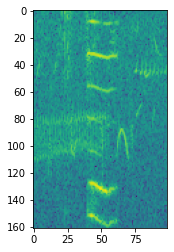

class: 0 likelihood: 0.875 total value: 19
class: 1 likelihood: 0.027 total value: 1
class: 2 likelihood: 0.098 total value: 2
most likely class: 1 10.215623852015206
most likely class: 1 16.26554512771904
most likely class: 1 9.09633753041435
most likely class: 1 11.609400107887964
most likely class: 1 29.148587531677787
most likely class: 1 79.26315256807138
most likely class: 1 99.21807541599601
most likely class: 0 53.258754538742366


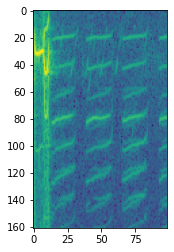

class: 0 likelihood: 1.0 total value: 53
class: 1 likelihood: 0.0 total value: 0
class: 2 likelihood: 0.0 total value: 0
most likely class: 0 6.517311978128838


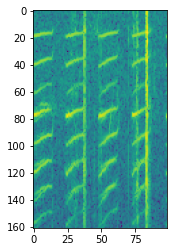

class: 0 likelihood: 1.0 total value: 7
class: 1 likelihood: 0.0 total value: 0
class: 2 likelihood: 0.0 total value: 0
most likely class: 1 13.611891228580047
most likely class: 1 8.872475489705376
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor8\20240601_090000.WAV
file length  169920000
about to make predictions on 2 images.
1/1 [==============================] - 0s 96ms/step
most likely class: 2 1.1998711358482157
most likely class: 2 0.8062917708926234
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor8\20240601_100000.WAV
file length  169920000
about to make predictions on 7 images.
1/1 [==============================] - 0s 100ms/step
most likely class: 1 3.2541200417605873
most likely class: 1 3.9724100634672954
most likely class: 1 5.539307123493794
most likely class: 1 5.877227381975041
most likely class: 1 4.862504363054209
most likely class: 1 3.074367025058069
most likely class: 1 5.518579478166825
processing D:\Grassland\Data\Recordings\Richardso

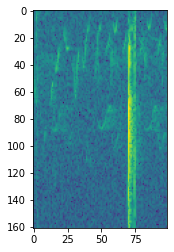

class: 0 likelihood: 0.35 total value: 3
class: 1 likelihood: 0.316 total value: 3
class: 2 likelihood: 0.334 total value: 3
most likely class: 1 15.818406380070025
most likely class: 2 8.299075708031427
most likely class: 2 11.867650227694769
most likely class: 2 11.577407138496993
most likely class: 1 1.1221872248884293
most likely class: 1 14.35030564906996
most likely class: 1 10.069819383093344
most likely class: 2 9.1345637775091
most likely class: 2 10.646693036843148
most likely class: 2 9.496994545347514
most likely class: 2 15.94188654934829
most likely class: 2 14.11315743551469
most likely class: 1 9.596968277314406
most likely class: 2 11.564847358319597
most likely class: 2 9.879399248385148
most likely class: 1 13.8441964365356
most likely class: 2 15.159291954112616
most likely class: 2 11.382631024582798
most likely class: 2 8.563501132438702
most likely class: 2 11.343687867529418
most likely class: 2 15.221022721642843
most likely class: 2 4.006272671989838
most like

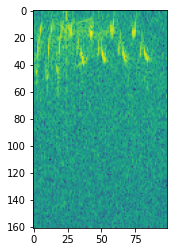

class: 0 likelihood: 0.544 total value: 1
class: 1 likelihood: 0.342 total value: 1
class: 2 likelihood: 0.115 total value: 0
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor8\20240601_120000.WAV
file length  169920000
about to make predictions on 107 images.
4/4 [==============================] - 0s 62ms/step
most likely class: 2 1.3392419467952579
most likely class: 2 1.531806893190687
most likely class: 2 9.426657893122453
most likely class: 2 9.659312880780496
most likely class: 1 14.18149698816067
most likely class: 2 8.435342734446461
most likely class: 1 12.875450524639302
most likely class: 2 13.134666800995783
most likely class: 2 8.472089216848927
most likely class: 2 16.04200931098694
most likely class: 1 14.288455167057437
most likely class: 2 12.691073541794692
most likely class: 2 7.520310760879177
most likely class: 1 13.916881252838698
most likely class: 2 12.874954905969156
most likely class: 1 14.13583991025177
most likely class: 2 4.972554805231026
most

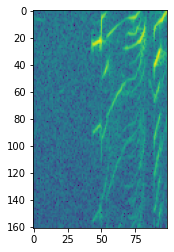

class: 0 likelihood: 0.629 total value: 3
class: 1 likelihood: 0.361 total value: 2
class: 2 likelihood: 0.01 total value: 0
most likely class: 1 9.211964037102598
most likely class: 1 8.118424190181653
most likely class: 1 13.403027512838587
most likely class: 1 9.244260854984967
most likely class: 1 4.033302309142137
most likely class: 1 2.639825204800754
most likely class: 1 3.3836212128958416
processing D:\Grassland\Data\Recordings\Richardson 2024\Sensor9\20240601_110000.WAV
file length  169920000
about to make predictions on 14 images.
1/1 [==============================] - 0s 115ms/step
most likely class: 1 5.438561700855595
most likely class: 2 2.130852150096236
most likely class: 1 3.552896922158965
most likely class: 1 3.8356593787724216
most likely class: 1 4.583936373581615
most likely class: 1 3.546297721686246
most likely class: 1 5.1161628220471504
most likely class: 1 3.7630491930614536
most likely class: 1 8.413110638514128
most likely class: 2 4.117046533845994
most li

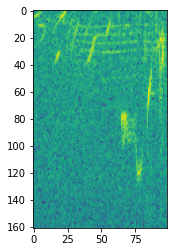

class: 0 likelihood: 0.782 total value: 2
class: 1 likelihood: 0.009 total value: 0
class: 2 likelihood: 0.209 total value: 1
most likely class: 1 5.416305458232047
most likely class: 2 6.135030162965154
most likely class: 2 1.8212059832997025
most likely class: 2 1.9216552847200592
most likely class: 2 2.5793168490123333
most likely class: 2 2.6269814503925897
most likely class: 2 2.4220497720092116
most likely class: 2 1.981380361467297
most likely class: 2 4.175471994596793
most likely class: 2 3.1817684266466673
most likely class: 2 5.8696111424622135
most likely class: 1 4.059676874169398
most likely class: 2 5.537735854892375
most likely class: 2 2.878061687463517
most likely class: 2 4.757448483053712
most likely class: 2 13.610430348552761
most likely class: 2 9.068615674791081
most likely class: 2 2.8787092385046664
most likely class: 2 2.1884456306358504
most likely class: 2 3.4588500629004453
most likely class: 2 2.321536818640021
most likely class: 2 2.411724241298038
most 

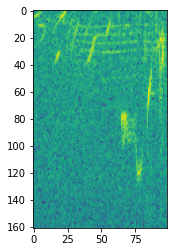

In [ ]:
import tensorflow as tf
# Helper libraries
import numpy as np
from librosa import display
import scipy
import math
import os
from tensorflow.keras.layers.experimental import keras.layers

def process_locations(model,classLabels,path,sampling_rate,segment_length,minAmp,buckets={}):
  dirs = os.listdir(path)
  currLoc=0
  #two layers of dirs
  for entry in dirs:
    currLoc=currLoc+1
    loc_path=os.path.join(path, entry)
    if os.path.isdir(loc_path):
      if not entry in buckets:
        #no bucket set for this location yet
        buckets[entry]=[0 for i in range(len(classLabels))] 
      loc_bucket=buckets[entry]
      #print("processing "+loc_path)
      files=os.listdir(loc_path)
      for file in files:
        process_location_file(model,os.path.join(loc_path,file),buckets[entry],sampling_rate,segment_length,segment_length,minAmp)
  for b in buckets:
    bucket=buckets[b]
    for i in range(len(bucket)):
      print("class "+str(i)+" total: "+str(round(bucket[i],2)))
    

def process_location_file(model,path,buckets,sampling_rate=44100,segment_length=44100,shift=44100,minAmp=0.01):
  #process a file from a location and add the amplitude to the bucket for each identified class
  display=False
  images=[] #np.empty((0,161,149))
  
  classes=[]
  amps=[]
  divisor=0.01
  save_path=os.path.join("D:",os.sep,"Grassland","Data","Classified","class_")
  if  (".wav" in path or ".WAV" in path) and filter in path:
    print("processing "+path)
    sounds=splice_sound_file(path,segment_length,shift)
    count=0
    for sound in sounds:
      count = count+1
      (maxAmp,avgAmp,sumAmp)=eval_amplitude(sound)
      if display:
        print("Sum amp: "+str(sumAmp)+" avg Amp: "+str(avgAmp))
      if maxAmp >= minAmp:
        #Only use if file reaches minimum amplitude
        spec=spectrogram(sound,sampling_rate)
        images.append(spec)
        amps.append(sumAmp)
        # if(display):
        #   plt.imshow(spec)
        #   plt.xlabel(path+" Time frame windows")
        #   plt.ylabel("Frequency")
        #   plt.show()
        #now find class of image
    if len(images) >0:
      images=np.stack(images)
      #normalize first
      layer = keras.layers.Normalization()
      layer.adapt(images) 
      normalized_images = layer(images)
      
      print("about to make predictions on "+str(len(images))+" images.")
      (probability_model,predictions)=make_predictions(model,normalized_images)
      numImages=len(normalized_images)
      display2=False
      for i in range(numImages):
        display2=False
        #print(str(i)+" of "+str(numImages))
        predict=predictions[i]
        amp=amps[i]
        cls=np.argmax(predict)
        print("most likely class: "+str(cls) + " "+str(amp))
        if cls==0:
          display2=True
        if display or display2:
          plt.imshow(images[i])
          plt.show() 
          spec_to_file(images[i],save_path+str(cls)+"_"+str(i))
        for c in range(len(predict)):
          #add the probabilistic amplitude to bucket (amp * probability of class c)
          buckets[c]+=amp*predict[c]*divisor
          if (display or display2):
            #print("predicted class: "+str(c))
            print("class: "+str(c)+" likelihood: "+str(round(predict[c],3))+" total value: "+str(round(amp*predict[c])))

  #process location sound files with a saved model

import csv

def load_bucket_file(file_path, num_classes):
  buckets={}
  #encode as follows to remove first BOM character 
  with open(file_path,encoding='utf-8-sig') as csvDataFile:
      csvReader = csv.reader(csvDataFile)
      for row in csvReader:
        location=row[0]
        classNum=int(row[1])
        value=float(row[2])
        if not location in buckets:
          b = [0 for i in range(num_classes)] 
          buckets[location]=b
        bucket=buckets[location]
        bucket[classNum]=value
  return buckets
          
def save_bucket_file(file_path,buckets):
  with open(file_path, 'w', newline='',encoding='utf-8-sig') as csvfile:
    csvWriter=csv.writer(csvfile,delimiter=',')
    
    for loc in buckets.keys():
      bucket=buckets[loc]
      i=0
      for v in bucket: #each class
        row=[loc,str(i),str(v)]
        i=i+1 #increment class num
        csvWriter.writerow(row)


filter="0601"   



#labels=["background_noise","bobof_whine","bobom_buzz","bobom_song","bobo_chunk","bobo_flight","chipping_sparrow","goldfinch","hammer","house_finch","house_sparrow","perch","red_eyed_vireo","robin","saw","song_sparrow","tree_swallow","warblers","wind"]
labels=["bobof_whine","bobom","misc"]
#labels=["bobof_whine","everything_else"u
bucket_file= os.path.join("D:",os.sep,"Grassland","Analysis","Richardson Analysis","bird_buckets_6_1.csv")
buckets=load_bucket_file(bucket_file,len(labels))
print(buckets)
lmodel=tf.keras.models.load_model(os.path.join("D:",os.sep,"Grassland","Models","Richardson_2024_2"))
process_locations(lmodel,labels,os.path.join("D:",os.sep,"Grassland","Data","Recordings","Richardson 2024"),44100,44100,0.01,buckets)

#save_bucket_file(bucket_file,buckets)